In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

import os

import logging as log

import scipy.stats as stats
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()

%matplotlib inline

In [2]:
log.getLogger().setLevel(20)

In [3]:
all_params = {}
all_runs = None

def get_params(run):
    result = {}
    params = ds[ds.type == "param"]
    for index, row in params[params.run == run].iterrows():
        # Try conversion. If fail, store string
        try:
            result[row.attrname] = float(row.attrvalue)
        except ValueError:
            result[row.attrname] = row.attrvalue
    return result

def build_params(ds):
    global all_params, all_runs
    
    all_params = {}
    all_runs = ds.run.unique()
    for run in all_runs:       
        all_params[run] = get_params(run)

In [4]:
run = "WorkingDayVarying*"
os.system(f"scavetool x ../results/{run}.sca ../results/{run}.vec -o /tmp/measurements.csv")
ds = pd.read_csv("/tmp/measurements.csv", low_memory=False)
build_params(ds)

In [5]:
def find_runs(**params):
    global ds
    
    result = []
    
    for run in all_runs:       
        run_params = all_params[run]
                
        for name, value in params.items():
            if type(value) is str:
                check_value = '"'+value+'"'
            else:
                check_value = value
                
            if name not in run_params or run_params[name] != check_value:
                log.debug(f"{run_params} fails {name}, expected {check_value}, found {run_params[name] if name in run_params else 'None'}")
                break
        else: # loop was not interrupted 
            result.append(run)
                
    return result
                          
def find_run(**params):
    result = find_runs(**params)
    if len(result) == 0:
        log.warning("No run found")
        return None
    elif len(result) > 1:
        log.warning("Provided parameters match multiple runs.")
    
    return result[0]
   

In [6]:
def get_scalar(run, module, name):
    strvalue = ds[(ds.type == "scalar") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].value
    try:
        return float(strvalue)
    except ValueError:
        log.warning("Scalar is not a number: " + strvalue)
        return strvalue

def get_avg_rt(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:mean"
    
    module = "Network.exit"
                          
    return get_scalar(run, module, name)

def get_avg_wt(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:mean"
    
    return get_scalar(run, module, name)

def get_avg_nq(run, module, vip = False, fifo = False):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if fifo:
        name += "fifo"
    elif vip:
        name += "vip"
    else:
        name += "normal"

    name += "QueueLength:timeavg"
    
    return get_scalar(run, module, name)
          

In [7]:
def get_vecvalue(run, module, name):
    try:
        return np.fromstring(ds.query("type=='vector' and run==@run and name==@name and module==@module").iloc[0].vecvalue, 
                             sep=" ", dtype=np.double)
    except Exception:
        log.warning("No vector found")
        return np.array([])
    
def get_vectime(run, module, name):
    try:
        return np.fromstring(ds[(ds.type == "vector") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].vectime, 
                             sep=" ", dtype=np.double)
    except Exception:
        log.warning("No vector found")
        return np.array([])

def get_rt(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:vector"
    
    module = "Network.exit"
                          
    return get_vecvalue(run, module, name)

def get_rt_time(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:vector"
    
    module = "Network.exit"
                          
    return get_vectime(run, module, name)

def get_wt(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:vector"
    
    return get_vecvalue(run, module, name)

def get_wt_time(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:vector"
    
    return get_vectime(run, module, name)

In [8]:
def hol_wait_time(vip, normArrivalRate, vipArrivalRate, serviceRate):
    if not vip:
        return ((normArrivalRate + vipArrivalRate)/((serviceRate-vipArrivalRate)*(serviceRate-normArrivalRate-vipArrivalRate)))
    else:
        return ((normArrivalRate + vipArrivalRate)/(serviceRate*(serviceRate-vipArrivalRate)))
    
def hol_resp_time(vip, normArrivalRate, vipArrivalRate, serviceRate):
    return hol_wait_time(vip, normArrivalRate, vipArrivalRate, serviceRate) + 1 / serviceRate

In [9]:
def mm1_resp_time(arrivalRate, serviceRate):
    return 1/(serviceRate - arrivalRate)

def mm1_wait_time(arrivalRate, serviceRate):
    return mm1_resp_time(arrivalRate, serviceRate) - 1/serviceRate

def mm1_queue_length(arrivalRate, serviceRate):
    rho = arrivalRate/serviceRate
    return rho/(1-rho)-rho

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n-1:] = ret[n - 1:] / n
    ret[:n-1] = ret[:n-1] / np.arange(1,n)
    return ret

In [11]:
def hourly_average(runs):
    lines = []
    for run in runs:
        line = []
        args = [run, vip, compound]
        rt = get_rt(*args)
        st = get_rt_time(*args)
        for i in range(18):
            mask = np.logical_and(st >= 60*i, st < 60*(i+1))
            line.append(np.mean(rt[mask]))
        lines.append(line)
    return lines

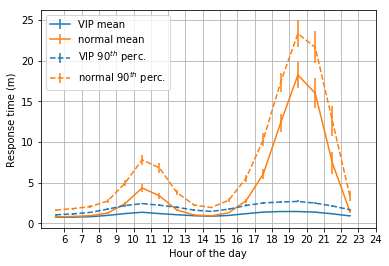

In [28]:
plt.figure(figsize=(6,4))
compound = False
cashier_rate = 1.5
runs = find_runs(**{"**.cashier.rate": cashier_rate, "**.customerSpawn.normalRate": 1.1})

for vip in [True, False]:
    lines = []
    for i_run, run in enumerate(runs):
        line = []
        args = [run, vip, compound]
        rt = get_rt(*args)
        st = get_rt_time(*args)
        for i in range(18):
            mask = np.logical_and(st >= 60*i, st < 60*(i+1))
#                 if not np.any(mask):
#                     print(vip, i_run, i, "NO POINTS")
            line.append(np.mean(rt[mask]))
        lines.append(line)
    arr = np.array(lines)
    means = np.nanmean(arr, axis=0)
    yerrs = []
    for i in range(18):
        arr_col = arr[:,i]
        arr_col_not_nan = arr_col[~np.isnan(arr_col)]
        interval = stats.t.interval(0.95, len(arr_col_not_nan)-1, loc=means[i], scale=stats.sem(arr_col_not_nan))
        yerrs.append(interval[1] - means[i])
    plt.errorbar(np.arange(0, 18)+5.5, means, fmt="C0-" if vip else "C1-", yerr=yerrs, label=("VIP" if vip else "normal")+" mean")
        
for vip in [True, False]:
    lines = []
    for i_run, run in enumerate(runs):
        line = []
        args = [run, vip, compound]
        rt = get_rt(*args)
        st = get_rt_time(*args)
        for i in range(18):
            mask = np.logical_and(st >= 60*i, st < 60*(i+1))
            if np.any(mask):
                line.append(np.percentile(rt[mask], 90))
            else:
                line.append(np.nan)
        lines.append(line)
    arr = np.array(lines)
    means = np.nanmean(arr, axis=0)
    yerrs = []
    for i in range(18):
        arr_col = arr[:,i]
        arr_col_not_nan = arr_col[~np.isnan(arr_col)]
        interval = stats.t.interval(0.95, len(arr_col_not_nan)-1, loc=means[i], scale=stats.sem(arr_col_not_nan))
        yerrs.append(interval[1] - means[i])
    plt.errorbar(np.arange(0, 18)+5.5, means, fmt="C0--" if vip else "C1--", yerr=yerrs, label=("VIP" if vip else "normal")+" $90^{th}$ perc.")

plt.grid(True, 'both')
plt.xticks(np.arange(0, 19)+6)
plt.ylabel("Response time (m)")
plt.xlabel("Hour of the day")
plt.legend()
plt.savefig("/tmp/vip_vs_normal_%s.pdf" % ('compound' if compound else 'simple'), bbox_inches='tight')

1.3
1.4
1.5
1.6
1.7
1.8


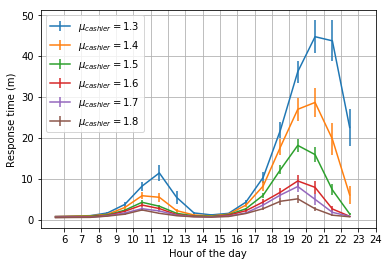

In [39]:
plt.figure(figsize=(6,4))
for cashier_rate in [1.3, 1.4, 1.5, 1.6, 1.7, 1.8]:
    print(cashier_rate)
    runs = find_runs(**{"**.cashier.rate": cashier_rate, "**.customerSpawn.normalRate": 1.1})
    data = []
    compound = False
    vip = False
    lines = []
    for i_run, run in enumerate(runs):
        line = []
        args = [run, vip, compound]
        rt = get_rt(*args)
        st = get_rt_time(*args)
        for i in range(18):
            mask = np.logical_and(st >= 60*i, st < 60*(i+1))
#                 if not np.any(mask):
#                     print(vip, i_run, i, "NO POINTS")
            line.append(np.mean(rt[mask]))
        lines.append(line)
    arr = np.array(lines)
    means = np.nanmean(arr, axis=0)
    yerrs = []
    for i in range(18):
        arr_col = arr[:,i]
        arr_col_not_nan = arr_col[~np.isnan(arr_col)]
        interval = stats.t.interval(0.95, len(arr_col_not_nan)-1, loc=means[i], scale=stats.sem(arr_col_not_nan))
        yerrs.append(interval[1] - means[i])
    plt.errorbar(np.arange(0, 18)+5.5, means, yerr=yerrs, label=f"$\\mu_{{cashier}} = {cashier_rate:.1f}$")
plt.grid(True, 'both')
plt.xticks(np.arange(0, 19)+6)
plt.ylabel("Response time (m)")
plt.xlabel("Hour of the day")
plt.legend()
plt.savefig('/tmp/varying_cashier_rate.pdf', bbox_inches='tight')

1
1.1
1.2
1.3


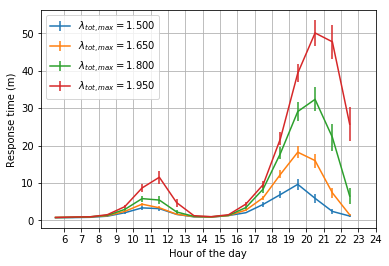

In [38]:
plt.figure(figsize=(6,4))
for normal_rate in [1, 1.1, 1.2, 1.3]:
    print(normal_rate)
    runs = find_runs(**{"**.cashier.rate": 1.5, "**.customerSpawn.normalRate": normal_rate})
    data = []
    compound = False
    vip = False
    lines = []
    for i_run, run in enumerate(runs):
        line = []
        args = [run, vip, compound]
        rt = get_rt(*args)
        st = get_rt_time(*args)
        for i in range(18):
            mask = np.logical_and(st >= 60*i, st < 60*(i+1))
#                 if not np.any(mask):
#                     print(vip, i_run, i, "NO POINTS")
            line.append(np.mean(rt[mask]))
        lines.append(line)
    arr = np.array(lines)
    means = np.nanmean(arr, axis=0)
    yerrs = []
    for i in range(18):
        arr_col = arr[:,i]
        arr_col_not_nan = arr_col[~np.isnan(arr_col)]
        interval = stats.t.interval(0.95, len(arr_col_not_nan)-1, loc=means[i], scale=stats.sem(arr_col_not_nan))
        yerrs.append(interval[1] - means[i])
    plt.errorbar(np.arange(0, 18)+5.5, means, yerr=yerrs, label=f"$\\lambda_{{tot,max}} = {normal_rate/0.8*1.2:.3f}$")
plt.grid(True, 'both')
plt.legend()
plt.xticks(np.arange(0, 19)+6)
plt.ylabel("Response time (m)")
plt.xlabel("Hour of the day")
plt.savefig('/tmp/varying_arrival_rate.pdf', bbox_inches='tight')

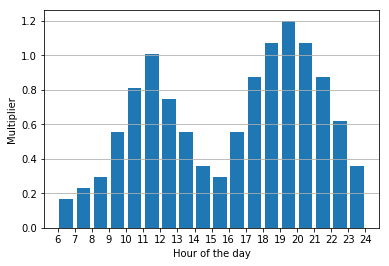

In [44]:
plt.figure(figsize=(6,4))
plt.grid(True, 'major', 'y')
plt.ylabel("Multiplier")
plt.xlabel("Hour of the day")
plt.xticks(np.arange(0, 19)+6)
plt.bar(np.arange(6, 24)+.5, [0.164705882,0.229411765,0.294117647,0.552941176,0.811764706,1.005882353,0.747058824,0.552941176,0.358823529,0.294117647,0.552941176,0.876470588,1.070588235,1.2,1.070588235,0.876470588,0.617647059,0.358823529])
plt.savefig('/tmp/input_bd.pdf', bbox_inches='tight')

Help on function grid in module matplotlib.pyplot:

grid(b=None, which='major', axis='both', **kwargs)
    Configure the grid lines.
    
    Parameters
    ----------
    b : bool or None
        Whether to show the grid lines. If any *kwargs* are supplied,
        it is assumed you want the grid on and *b* will be set to True.
    
        If *b* is *None* and there are no *kwargs*, this toggles the
        visibility of the lines.
    
    which : {'major', 'minor', 'both'}
        The grid lines to apply the changes on.
    
    axis : {'both', 'x', 'y'}
        The axis to apply the changes on.
    
    **kwargs : `.Line2D` properties
        Define the line properties of the grid, e.g.::
    
            grid(color='r', linestyle='-', linewidth=2)
    
        Valid *kwargs* are
    
          agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
      alpha: float
      animated: bool
      antialiased: bool
      clip